In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3 * x **2 - 4 * x + 5

In [3]:
f(3)

20

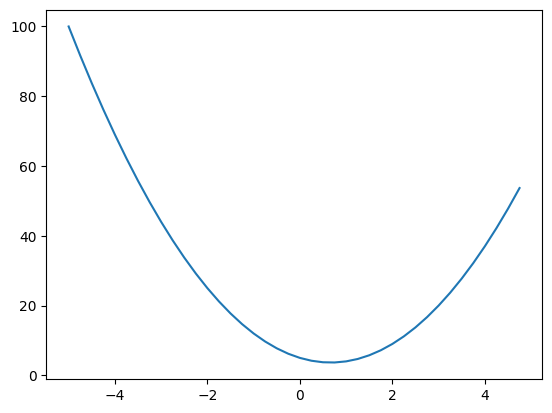

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)

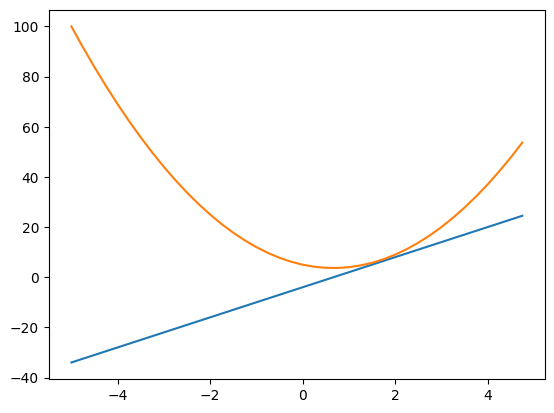

In [5]:
h = 0.000001

L = (f(xs + h) - f(xs)) / h

plt.plot(xs, L)
plt.plot(xs, ys)

In [6]:
a = 2.0
b = -3
c = 10

d = a * b + c

print(d)

4.0


In [7]:
a = 2.0
b = -3
c = 10

d1 = a * b + c
c += h
d2 = a * b + c

print(f"d1: {d1}")
print(f"d2: {d2}")
print(f"Slope: {(d2 - d1) / h}")

d1: 4.0
d2: 4.000000999999999
Slope: 0.9999999992515995


In [8]:
# Creating a value object
class Value:

    def __init__(self, data, _children=[], _op="", label=""):
        self.data = data
        self._backward = lambda: None
        self.grad = 0.0 # 0 means no change
        self._prev = set(_children) # using set only for efficiency
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        """Add function"""
        other = other if isinstance(other, Value) else Value(other)

        sum = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * sum.grad
            other.grad += 1.0 * sum.grad

        sum._backward = _backward

        return sum
    
    def __mul__(self, other):
        """Multiplication function"""
        other = other if isinstance(other, Value) else Value(other)

        prod = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * prod.grad 
            other.grad += self.data * prod.grad

        prod._backward = _backward
        return prod
    
    def __rmul__(self, other):
        """Reverse Multiplication"""
        return self * other
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        """tanh function"""
        x = self.data
        tanh = (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))

        output = Value(tanh, (self, ), "tanh")

        def _backward():
            self.grad += (1 - tanh ** 2) * output.grad

        output._backward = _backward
            
        return output
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f"**other")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self * other ** -1

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child in v._prev:
                    build_topo(child)
                
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b
e.label = "e"
f = Value(-2.0, label="f")
d = e + c
d.label = "d"

L = d * f
L.label = "L" 

In [9]:
!pip install graphviz


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)

            for child in v._prev:
                edges.add((child, v))

                build(child)
    build(root)

    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={'rankdir': "LR"})

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        dot.node(name=uid, label="{%s | data % .4f | grad %.4f}" % (n.label, n.data, n.grad), shape="record")

        if n._op:
            dot.node(name=uid+n._op, label=n._op)

            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

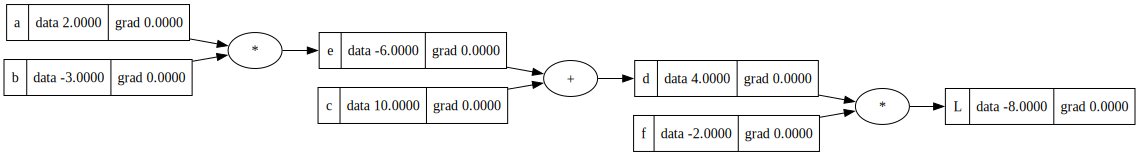

In [11]:
draw_dot(L)

In [12]:
L.grad = 1

In [13]:
f.grad = d.data
d.grad = f.data

In [14]:
e.grad = f.data
c.grad = f.data

In [15]:
a.grad = f.data * b.data
b.grad = f.data * a.data

In [16]:
# Now 2nd epoch for forward propagation
learning_rate = 0.01

a.data += learning_rate * a.grad
b.data += learning_rate * b.grad

In [17]:
c.data += learning_rate * c.grad
f.data += learning_rate * f.grad

In [18]:
e = a * b
d = e + c
L = d * f

In [19]:
e.label = "e"
d.label = "d"
L.label = "L"

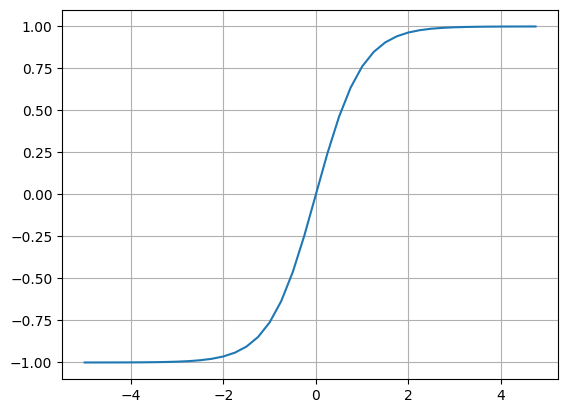

In [20]:
xs = np.arange(-5, 5, 0.25)
ys = np.tanh(xs)

plt.plot(xs, ys)
plt.grid()

In [21]:
# Inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# Weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1; x1w1.label="x1w1"
x2w2 = x2 * w2; x2w2.label="x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b; n.label="n"

# o = n.tanh()
e = (2*n).exp(); e.label = "e"
o = (e - 1 )/ (e + 1)

o.label = "o"

In [22]:
b + 2

Value(data=8.881373587019542)

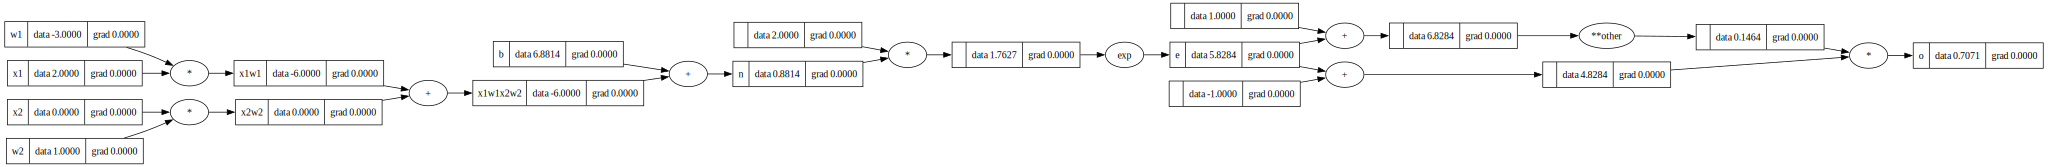

In [23]:
draw_dot(o)

In [24]:
o.backward()

In [25]:
# o.grad = 1 

# topo = []
# visited = set()

# def build_topo(v):
#     if v not in visited:
#         visited.add(v)

#         for child in v._prev:
#             build_topo(child)
        
#         topo.append(v)

# build_topo(o)

# for node in reversed(topo):
#     node._backward()

In [26]:
# o._backward()   

In [27]:
# n._backward()

In [28]:
# x1w1x2w2._backward()

In [29]:
# x1w1._backward()
# x2w2._backward()

In [30]:
# # using topological sort for implementing backward propagation for all

# topo = []
# visited = set()

# def build_topo(v):
#     if v not in visited:
#         visited.add(v)

#         for child in v._prev:
#             build_topo(child)
        
#         topo.append(v)

# build_topo(o)

# topo

## Doing the same but now in pytorch

In [31]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cu118


In [32]:
import torch

# The requires grad here allows back propagation.
# By default it is set to False for efficiency reasons ofc, if you do not initialize it you cannot perform back propagation on that particular element. 

# By default the tensors are single precision i.e float 32
# by typecasting it to double we turn it into float 64
x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.881373587019543]).double()  ; b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item()) # same as o.item()
o.backward()

print("---")
print("x1", x1.grad.item())
print("x2", x2.grad.item())
print("w1", w1.grad.item())
print("w2", w2.grad.item())

0.7071066904050358
---
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [33]:
a = torch.Tensor([1])
a

tensor([1.])

## Creating a Multi Layer Perceptrop

In [34]:
import random

class Neuron:
    def __init__(self, num_input: int) -> None:
        """
        Initialization function for a Neuron

        Parameters:
            - self (Neuron): self
            - num_inputs (int): Number of inputs going in the neuron
        
        Returns:
            - None
        """
        self.w = [Value(random.uniform(-1, 1)) for _ in range(num_input)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x: list):
        """
        This describes the call function of the Neuron class
        Can also be regarded as the forward pass for the neuron

        Parameters:
            - self (Neuron): self
            - x (list): List of xs
        
        Returns:
            - None
        """


        sum = Value(0)
        for wi, xi in zip(self.w, x):
            sum += wi * xi

        n = sum + self.b

        o = n.tanh()

        return o
    
    def parameters(self):
        """
        Description: This function returns a list of all parameters like weights an biases in a neutron
        """
        return self.w + [self.b]

x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.58015196025947)

In [35]:
class Layer:

    def __init__(self, num_inputs: int, num_neurons: int) -> None:
        """
        Description:
            - This function initializes the Layer class
        
        Parameters:
            - num_inputs (int): number of inputsm, We can use them to create the number of inputs coming in the neuron
            - num_neurons (int): Describes the number of neurons in a layer. 

        Returns:
            - None 
        """

        self.neurons = [Neuron(num_inputs) for _ in range(num_neurons)]

    def __call__(self, x):
        """
        Description:
            - This is the call function of the neuron
        
        Parameters:
            - self (Layer): self
            - x (list): list of inputs

        Returns:
            - list
        """

        outs = [n(x) for n in self.neurons]

        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        """
        Description: This function returns a list of parameters in a layer
        """
        # params = []

        # for neuron in self.neurons:
        #     params.extend(neuron.parameters()) # We use extend instead of append because append would have just added the arrays but extend will add the elements

        return [p for neuron in self.neurons for p in neuron.parameters()]
    
x = [2.0, 3.0]
len_x = len(x)

num_of_neurons_in_each_layer = 3 # This describes the number of neurons in each layer, it is a hyperparameter that can be tweeked accordingly.

n = Layer(len_x, num_of_neurons_in_each_layer)
n(x)

# The outputs received is basically the outputs of 3 neurons which will act as the input to the other layer

[Value(data=-0.12128501791255146),
 Value(data=0.9718248731777468),
 Value(data=-0.40549798493938594)]

In [36]:
class MLP:

    def __init__(self, num_of_inputs: int, list_of_num_of_neurons: list) -> None:
        """
        Description:
            - This function is the initialization function of the MLP
        
        Parameters:
            - self (MLP)
            - num_of_inputs (int): number of inputs present in the dataset. 
            - list_of_num_of_neurons (list): list of number of neurons in each layer, this is a hyper-parameter that can be changed based on the size of the dataset
        """

        self.layers = [Layer(num_of_inputs, num_neurons) for i, num_neurons in enumerate(list_of_num_of_neurons)]

    def __call__(self, x):
        """
        Description:
            - This function describes the call operation

        Parameters:
            - self: self 
            - x (list): input variables
        """

        for layer in self.layers:
            x = layer(x)

        return x
    
    def parameters(self):
        """
        Description: This function returns all the parameters present in the MLP
        """
        # params = []
        # for layer in self.layers:
        #     params.extend(layer.parameters())

        return [parameter for layer in self.layers for neuron in layer.neurons for parameter in neuron.parameters()]

In [37]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7542535925040812)

In [38]:
len(n.parameters())

36

In [39]:
xs = [
    [2.0, 3.0, -1.0], 
    [3.0, -1.0, 0.5], 
    [0.5, 1.0, 1.0], 
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]



In [40]:
# FORWARD PASS
ypred = [n(x) for x in xs]


# LOSS CALCULATION
i = Value(0)

for y_truth, y_output in zip(ys, ypred):
    i += (y_output - y_truth) ** 2

# We square so that we only get positive numbers

# loss = sum([(y_output - y_truth)**2 for y_truth, y_output in zip(ys, ypred)]) 

loss = i
loss

Value(data=6.486306925124017)

In [41]:
# BACK PROPAGATION
loss.backward()

In [42]:
n.layers[0].neurons[0].w[0].grad

-0.013910867563069857

In [43]:
n.layers[0].neurons[0].w[0].data

0.9550582504304079

In [44]:
for parameter in n.parameters():
    parameter.data += -0.01 * parameter.grad # We add the minus sign because we want to move towards the opposite direction of the grad/deriavative. 

In [45]:
n.layers[0].neurons[0].w[0].data

0.9551973591060386

In [46]:
ypred

[Value(data=0.7542535925040812),
 Value(data=0.7827587543840148),
 Value(data=0.7939404873899292),
 Value(data=0.828348085658194)]

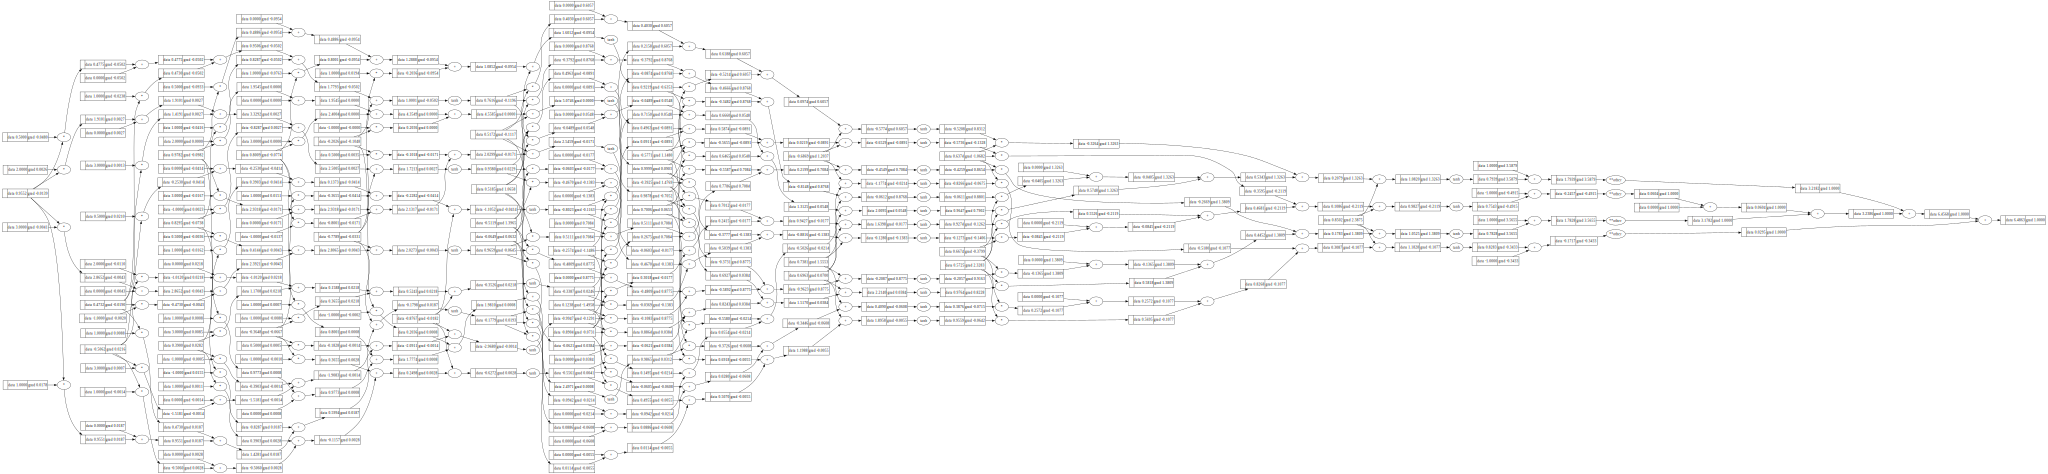

In [47]:
draw_dot(loss)


## There is a very common mistake done here, I am keeping the code as it is and updating in the next cell. 

In [48]:
# # A RESPECTABLE TRAINING LOOP
# losses = []
# epochs = 100
# learning_rate = 0.01
# for k in range(epochs):

#     # 1. Forward Propagation
#     y_pred = [n(x) for x in xs]
#     print(y_pred)
#     # 2. Loss Calculation
#     loss = Value(0)

#     for yp, yo in zip(y_pred, ys):
#         loss += (Value(yo) - yp) ** 2
    
#     # 3. Back Propagation
#     loss.backward()

#     # 4. Updating weights
#     for parameter in n.parameters():
#         parameter.data += -learning_rate * parameter.grad

#     # 5. Print epoch details
#     losses.append(loss.data)
#     print(f"Epoch: {k} | Loss: {loss.data}")

# So the bug here is that after 1 epoch, we do not flush out the old grad values. 
After every epoch i.e forward + backward, you have to set the grad of all the parameters to 0, why?
Because if you don't they keep acculmulating and cause problems

You might have noticed that the graph formed there was very steep that is, it took big steps to reach the minima. It is because we didn't set the grad to 0
and it kept accumulating making the weights to take big steps. And because the data was simpler, it was still able to fit with bigger steps. 

After fixing the bug, we can now see that it takes much more steps to reach the minima. 

In [51]:
# A RESPECTABLE TRAINING LOOP
losses = []
epochs = 100
learning_rate = 0.01
for k in range(epochs):

    # 1. Forward Propagation
    y_pred = [n(x) for x in xs]
    # print(y_pred)
    # 2. Loss Calculation
    loss = Value(0)

    for yp, yo in zip(y_pred, ys):
        loss += (Value(yo) - yp) ** 2
    
    # 3. Back Propagation
    for p in n.parameters():
        p.grad = 0.0
    
    loss.backward()

    # 4. Updating weights
    for parameter in n.parameters():
        parameter.data += -learning_rate * parameter.grad

    # 5. Print epoch details
    losses.append(loss.data)
    print(f"Epoch: {k} | Loss: {loss.data}")

Epoch: 0 | Loss: 0.09766322186871113
Epoch: 1 | Loss: 0.09633977254552761
Epoch: 2 | Loss: 0.09505021828003846
Epoch: 3 | Loss: 0.09379329977036818
Epoch: 4 | Loss: 0.09256781866354966
Epoch: 5 | Loss: 0.09137263393177314
Epoch: 6 | Loss: 0.09020665850368617
Epoch: 7 | Loss: 0.08906885613003049
Epoch: 8 | Loss: 0.08795823846480813
Epoch: 9 | Loss: 0.08687386234487579
Epoch: 10 | Loss: 0.08581482725240445
Epoch: 11 | Loss: 0.08478027294602322
Epoch: 12 | Loss: 0.08376937724771084
Epoch: 13 | Loss: 0.08278135397362121
Epoch: 14 | Loss: 0.08181545099804406
Epoch: 15 | Loss: 0.08087094844062032
Epoch: 16 | Loss: 0.07994715696775875
Epoch: 17 | Loss: 0.07904341619995682
Epoch: 18 | Loss: 0.0781590932174079
Epoch: 19 | Loss: 0.07729358115689926
Epoch: 20 | Loss: 0.07644629789356824
Epoch: 21 | Loss: 0.07561668480159707
Epoch: 22 | Loss: 0.07480420558839276
Epoch: 23 | Loss: 0.07400834519722851
Epoch: 24 | Loss: 0.07322860877370718
Epoch: 25 | Loss: 0.07246452069176819
Epoch: 26 | Loss: 0.071

Text(0, 0.5, 'Loss')

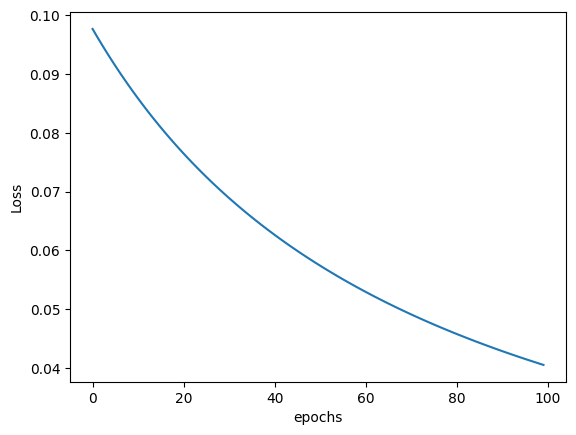

In [52]:
x_epochs = np.arange(0, epochs, 1)
plt.plot(x_epochs, losses)
plt.xlabel("epochs")
plt.ylabel("Loss")